In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, FCC
import numpy as np
import sys
from coffea.analysis_tools import PackedSelection, Cutflow
import awkward as ak
import pandas as pd
import dask_awkward as dak
import hist.dask as hda
from collections import namedtuple
import hist
import fastjet
import vector
vector.register_awkward()
import sys
import os
# local_dir = os.environ['LOCAL_DIR']
local_dir = '/home/prayag/coffeafcc/coffea-fcc-analyses/'
sys.path.append(local_dir)
import scripts
from scripts.analyzers import ReconstructedParticle as ReconstructedParticleUtil
from scripts.analyzers import Jet as JetUtil

plots = {
    'dijet_m':{'name':'dijet_higgs_m','title':'Dijet Higgs Mass','xlabel':'Dijet mass [GeV]','ylabel':'Events','bins':80,'xmin':70,'xmax':150},
    'pdgid':{'name':'jets_truth','title':'Jets Truth','xlabel':'Jet truth label PDGID','ylabel':'Events','bins':16,'xmin':-8,'xmax':8},
    'recoil':{'name':'zmumu_recoil_m','title':'Recoil from Z (mass)','xlabel':'Recoil [GeV]','ylabel':'Events','bins':200,'xmin':120,'xmax':140},
    'p_ll':{'name':'zmumu_p','title':'$Z\\rightarrow \\mu^{\\plus} \\mu^{\\minus}$ Momentum','xlabel':'$p\\left( \\mu^{\\plus} \\mu^{\\minus}\\right) \\ [GeV]$','ylabel':'Events','bins':50,'xmin':20,'xmax':70},
    'm_ll':{'name':'zmumu_m','title':'$Z\\rightarrow \\mu^{\\plus} \\mu^{\\minus}$ Mass','xlabel':'$m\\left( \\mu^{\\plus} \\mu^{\\minus}\\right) \\ [GeV]$','ylabel':'Events','bins':40,'xmin':70,'xmax':110},
}
plot_props = pd.DataFrame(plots)

/home/prayag/coffeafcc/development/coffea/src/coffea/nanoevents/schemas/edm4hep.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
from particle import Particle
def from_pdgid(array, doubly_nested=False):
    """
    Return an awkward array of names of particles
    from an awkward array of PDGIDs of the particles
    """
    def get_name(pdgid):
        try:
            s = str(Particle.from_pdgid(pdgid))
        except:
            s = 'unknown'
        return s
        
    def PDG_finder(layout, **kwargs):
        if layout.is_numpy:
            return ak.Array(
                [get_name(id) for id in layout.data]
            ).layout

    return ak.transform(PDG_finder, array)

In [83]:
def JetTruthFinder(jet_constituents, mc, findGluons = False):
    """
    Make sure that jets, jet_constituents and mc, all have
    the same number of events.

    We have to return the PDGID of the 
    best matched genParton to the jets (by inspecting its dr with the jet constituents)

    """
    mc = events.Particle[cuts.all()]
    findGluons = False
    if not findGluons: #only quarks
        parton_cut = (abs(mc.PDG) <= 6)
    else: #only quarks and gluons
        parton_cut = (abs(mc.PDG) <= 6) | (abs(mc.PDG) == 21)
    
    genPartons = mc[parton_cut]
    
    jetcon_b, genParton_b = ak.unzip(ak.cartesian((jet_constituents[:,:,np.newaxis], genPartons[:,np.newaxis])))
    all_dr = jetcon_b.deltaR(genParton_b)
    sum_dr = ak.sum(all_dr, axis=3)
    min_idx = ak.argmin(sum_dr, axis=2)

    return genPartons[min_idx]


def easier_JetTruthFinder(jets, mc, findGluons = False):
    """
    Make sure that jets, jet_constituents and mc, all have
    the same number of events.

    We have to return the PDGID of the 
    best matched genParton to the jets (by inspecting its dr with the jet constituents)

    But maybe there is a better way? What if we just find
    the dr between the resultant jets and the partons?
    """
    if not findGluons: #only quarks
        parton_cut = (abs(mc.PDG) <= 6)
    else: #only quarks and gluons
        parton_cut = (abs(mc.PDG) <= 6) | (abs(mc.PDG) == 21)

    genPartons = mc[parton_cut]

    jet_b, genParton_b = ak.unzip(ak.cartesian((jets, genPartons[:,np.newaxis])))
    all_dr = jet_b.deltaR(genParton_b)
    index = ak.argmin(all_dr, axis=2)

    matched_parton = genPartons[index]

    return matched_parton

In [84]:
fcc = FCC.get_schema()
events = NanoEventsFactory.from_root(
    # '../../data/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root:events',
    '../../data/wzp6_ee_mumuH_Hbb_ecm240/test_Winter2023.root:events',
    schemaclass=fcc,
    # entry_stop=10000,
    metadata={'dataset':'ZH'},
    delayed=True,
    uproot_options={"filter_name": lambda x : "PARAMETERS" not in x}
).events()

In [85]:
def get_1Dhist(name, var, flatten=False):
    '''
    name: eg. Zm
    var: eg. variable containing array of mass of Z
    flatten: If to flatten var before fill; True by default
    Returns a histogram
    '''
    props = plot_props[name]
    if flatten : var = dak.ravel(var) # Removes None values and all the nesting
    var = var[~dak.is_none(var, axis=0)] # Remove None values only
    return hda.Hist.new.Reg(props.bins, props.xmin, props.xmax).Double().fill(var)

In [86]:
# Object Selections
Muons = events.ReconstructedParticles.match_collection(events.Muonidx0)
sel_muon_p_gt_25 = Muons.p > 25.0
Muons = Muons[sel_muon_p_gt_25]
Z = ReconstructedParticleUtil.resonanceBuilder(Muons, 91.0)
Recoil = ReconstructedParticleUtil.recoilBuilder(Z, 240.0)

#Event Selections
cuts = PackedSelection()
cuts.add("n_gte_2_Muons", ak.num(Muons, axis=1) >= 2 )
cuts.add("m_gt_70_Z", Z.m > 70.0 )
cuts.add("m_lt_100_Z", Z.m < 100.0 )
cuts.add("p_gt_20_Z", Z.p > 20.0 )
cuts.add("p_lt_70_Z", Z.p < 70.0 )
cuts.add("m_gt_120_Recoil", Recoil.m > 120.0 )
cuts.add("m_lt_140_Recoil", Recoil.m < 140.0 )

# Apply the event selections
Good_Z = Z[cuts.all()]
Good_Recoil = Recoil[cuts.all()]

# The remove function removes those matched indices provided as argument 2
# To remove muons with p greater than 25, we have to use that cut on indices
# before passing on to the remove function
high_p_muon_indices = events.Muonidx0[sel_muon_p_gt_25]
rps_no_mu = ReconstructedParticleUtil.remove(events.ReconstructedParticles, high_p_muon_indices)
rps_no_mu = rps_no_mu[cuts.all()] #Apply all the event selections
pseudo_jets = ak.zip(
    {
    'px':rps_no_mu.px,
    'py':rps_no_mu.py,
    'pz':rps_no_mu.pz,
    'E':rps_no_mu.E
    },
    with_name="Momentum4D"
)
arg_sort_pt = ak.argsort(pseudo_jets.pt)
jetdef = fastjet.JetDefinition0Param(fastjet.ee_kt_algorithm)
jetdef.set_python_recombiner(JetUtil.E0_scheme)
#jetdef.description()
cluster = fastjet.ClusterSequence(pseudo_jets[arg_sort_pt], jetdef)
jets = cluster.exclusive_jets(2)
jet_constituents = cluster.exclusive_jets_constituents(2)
dijets = ak.sum(jets, axis=1)
quarks_matched_to_jets = JetTruthFinder(jet_constituents, events.Particle[cuts.all()])
pdgid = quarks_matched_to_jets.PDG

#Prepare output
#Choose the required histograms and their assigned variables to fill
names = plot_props.columns.to_list()
vars_sel = [
    dijets.m,
    ak.ravel(pdgid),
    Good_Recoil.m,
    Good_Z.p,
    Good_Z.m,
    dijets.m
]
sel_ocl = cuts.cutflow(*cuts.names).yieldhist()

Output = {
    'histograms': {
        'sel':{name:get_1Dhist(name,var,flatten=False) for name,var in zip(names,vars_sel)},
    },
    'cutflow': {
        'sel': {'Onecut':sel_ocl[0],'Cutflow':sel_ocl[1],'Labels':sel_ocl[2]},
    }
}

In [87]:
Output["histograms"]["sel"]

{'dijet_m': Hist(Regular(80, 70, 150, label='Axis 0'), storage=Double()) # (has staged fills),
 'pdgid': Hist(Regular(16, -8, 8, label='Axis 0'), storage=Double()) # (has staged fills),
 'recoil': Hist(Regular(200, 120, 140, label='Axis 0'), storage=Double()) # (has staged fills),
 'p_ll': Hist(Regular(50, 20, 70, label='Axis 0'), storage=Double()) # (has staged fills),
 'm_ll': Hist(Regular(40, 70, 110, label='Axis 0'), storage=Double()) # (has staged fills)}

In [88]:
a = Output["histograms"]["sel"]["dijet_m"].compute()
b = Output["histograms"]["sel"]["pdgid"].compute()
c = Output["histograms"]["sel"]["recoil"].compute()
d = Output["histograms"]["sel"]["p_ll"].compute()
e = Output["histograms"]["sel"]["m_ll"].compute()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f40c407b080>, errorbar=None, legend_artist=None)]

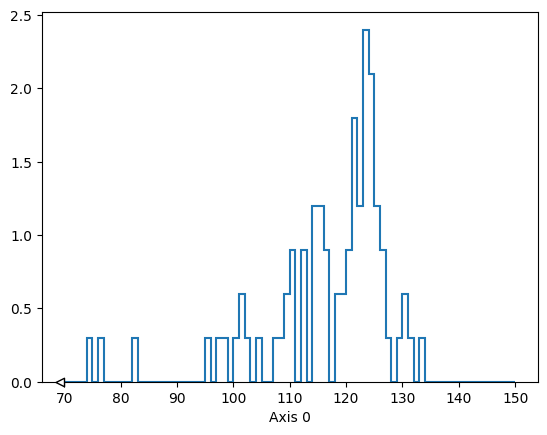

In [89]:
(a*0.3).plot()

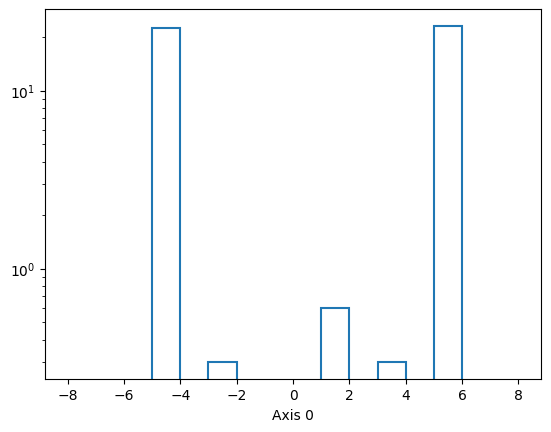

In [90]:
import matplotlib.pyplot as plt
fig, ax= plt.subplots()
(b*0.3).plot1d(ax=ax)
ax.set_yscale('log')

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f40c371b9b0>, errorbar=None, legend_artist=None)]

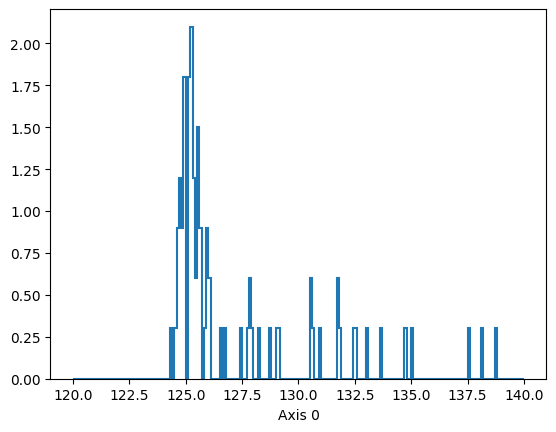

In [91]:
(c*0.3).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f40c36a39b0>, errorbar=None, legend_artist=None)]

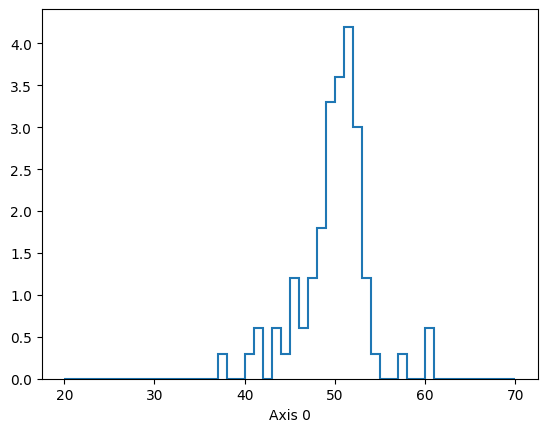

In [92]:
(d*0.3).plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f40c37ec590>, errorbar=None, legend_artist=None)]

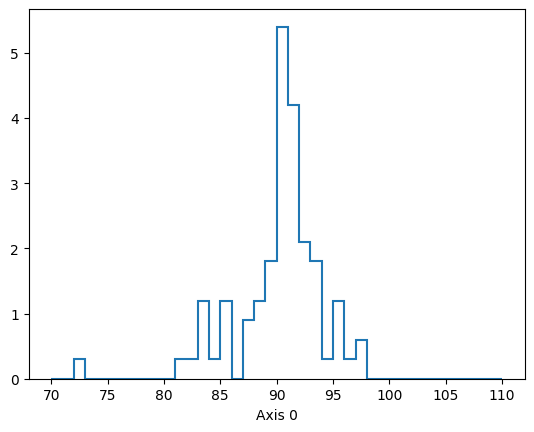

In [93]:
(e*0.3).plot()